In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from matspy import spy
import json
from pipeliner.recommendations.transformer import (
    UserItemMatrixTransformer,
    SimilarityTransformer,
)
from pipeliner.recommendations.recommender import SimilarityRecommender

In [29]:
# Create a toy dataset
OVERWRITE = False

NUM_USERS = 12
NUM_ITEMS = 24

# Create arrays for each column
# users = np.repeat(np.arange(NUM_USERS), 6)
# stacked = np.hstack([np.arange(NUM_ITEMS), np.arange(5)])
# strides = np.lib.stride_tricks.sliding_window_view(stacked, 6)[::2]
# items = strides.reshape(-1)
# ratings = np.tile([0.8, 0.4, 0.6, 0.2, 1.0, 0.8], (12, 1))
# rating_bias = np.expand_dims((np.arange(12)/100), 1)
# ratings = (ratings + rating_bias).reshape(-1)
# ratings = np.clip(ratings, 0.0, 1.0)

# print(users.shape, items.shape, ratings.shape, rating_bias.shape)

rating_options = np.array([0.2, 0.4, 0.6, 0.8, 0.8, 1.0])
users = np.tile(np.expand_dims(np.arange(NUM_USERS), 1), 8)
items = np.arange(NUM_ITEMS)
rated_items = np.array([np.random.choice(items, 8, replace=False) for _ in np.arange(NUM_USERS)])
ratings = np.array([np.random.choice(rating_options, 8) + (n/100) for n in np.arange(NUM_USERS)])
ratings = np.clip(ratings, 0.0, 1.0)



# Stack arrays to get (user, item, rating) combinations
user_item_ratings_generated = np.dstack([users, rated_items, ratings]).astype(np.float32).reshape((-1, 3))
# user_item_ratings_generated = np.column_stack((users, items, ratings)).astype(np.float32)

user_item_ratings_df = pd.DataFrame(
    user_item_ratings_generated, columns=["user_id", "item_id", "rating"]
)
user_item_ratings_df.user_id = user_item_ratings_df.user_id.astype(int).map(
    lambda i: f"U{i + 1:05d}"
)
user_item_ratings_df.item_id = user_item_ratings_df.item_id.astype(int).map(
    lambda i: f"I{i + 1:05d}"
)
if OVERWRITE:
    user_item_ratings_df.to_csv(
        "../../tests/test_data/user_item_ratings_toy.csv", index=False
    )
display(user_item_ratings_df.head(12))

,user_id,item_id,rating
0,U00001,I00014,0.80
1,U00001,I00016,1.00
2,U00001,I00008,0.40
3,U00001,I00011,0.60
4,U00001,I00018,0.60
5,U00001,I00021,0.40
6,U00001,I00010,0.20
7,U00001,I00022,1.00
8,U00002,I00015,0.21
9,U00002,I00024,0.61


In [30]:
users = user_item_ratings_df.user_id.unique()
items = user_item_ratings_df.item_id.unique()
user_item_matrix_transformer = UserItemMatrixTransformer()
user_item_matrix = user_item_matrix_transformer.transform(
    user_item_ratings_generated
)
user_item_matrix_df = pd.DataFrame(
    user_item_matrix, index=users, columns=items
).astype(np.float32)
user_item_matrix_df.index.name = "user_id"
display(user_item_matrix_df)

if OVERWRITE:
    user_item_matrix_df.to_csv(
        "../../tests/test_data/user_item_matrix_toy.csv", index=True
    )

user_similarity_matrix_transformer = SimilarityTransformer()
user_similarity_matrix = user_similarity_matrix_transformer.transform(user_item_matrix)
user_similarity_matrix_df = pd.DataFrame(
    user_similarity_matrix, index=users, columns=users
).astype(np.float32)
user_similarity_matrix_df.index.name = "user_id"
display(user_similarity_matrix_df)

if OVERWRITE:
    user_similarity_matrix_df.to_csv(
        "../../tests/test_data/user_similarity_matrix_toy.csv", index=True
    )

item_similarity_matrix_transformer = SimilarityTransformer()
item_similarity_matrix = item_similarity_matrix_transformer.transform(
    user_item_matrix.T
)
item_similarity_matrix_df = pd.DataFrame(
    item_similarity_matrix, index=items, columns=items
).astype(np.float32)
item_similarity_matrix_df.index.name = "item_id"
display(item_similarity_matrix_df)

if OVERWRITE:
    item_similarity_matrix_df.to_csv(
        "../../tests/test_data/item_similarity_matrix_toy.csv", index=True
    )

,I00014,I00016,I00008,I00011,I00018,I00021,I00010,I00022,I00015,I00024,...,I00020,I00019,I00002,I00005,I00012,I00009,I00007,I00003,I00017,I00006
user_id,,,,,,,,,,,,,,,,,,,,,
U00001,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.40,0.00,0.20,...,0.00,1.00,0.0,0.60,0.00,0.00,0.40,1.00,0.00,0.00
U00002,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.21,0.00,0.0,0.00,0.00,0.00,0.81,1.00,1.00,0.61
U00003,0.22,0.62,0.00,1.00,0.82,0.00,0.00,0.22,0.00,0.00,...,0.00,0.00,0.0,0.00,0.82,0.22,0.00,0.00,0.00,0.00
U00004,0.83,0.00,1.00,0.00,0.00,0.00,0.43,0.00,0.43,1.00,...,0.00,0.00,0.0,0.00,0.83,0.00,0.00,0.00,0.00,0.00
U00005,0.24,0.24,0.00,0.84,0.00,0.00,0.00,0.00,0.00,0.84,...,0.00,0.00,0.0,0.00,1.00,0.00,0.00,0.00,0.84,0.24
U00006,0.65,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.85,0.85,...,0.00,0.00,0.0,0.00,0.65,0.25,0.00,0.00,1.00,0.00
U00007,0.00,0.00,0.26,0.00,0.46,0.00,0.00,0.00,1.00,0.00,...,0.86,0.00,0.0,0.00,0.00,0.00,0.26,0.46,0.00,0.00
U00008,0.87,0.00,0.00,0.87,0.00,0.00,0.00,0.87,0.00,0.00,...,0.00,0.00,0.0,0.00,0.87,0.87,0.00,0.00,0.00,0.87
U00009,0.00,0.00,0.00,0.88,0.00,0.00,0.88,0.68,0.88,0.00,...,0.00,0.68,1.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


,U00001,U00002,U00003,U00004,U00005,U00006,U00007,U00008,U00009,U00010,U00011,U00012
user_id,,,,,,,,,,,,
U00001,1.000000,0.452719,0.159675,0.043253,0.144458,0.127739,0.317766,0.233557,0.366614,0.072202,0.288718,0.391804
U00002,0.452719,1.000000,0.235112,0.112663,0.517867,0.191388,0.253737,0.433714,0.301144,0.222172,0.219257,0.632475
U00003,0.159675,0.235112,1.000000,0.191183,0.529638,0.406464,0.326155,0.494330,0.233437,0.407811,0.191057,0.053051
U00004,0.043253,0.112663,0.191183,1.000000,0.417757,0.413682,0.224872,0.308519,0.255901,0.292976,0.314464,0.231102
U00005,0.144458,0.517867,0.529638,0.417757,1.000000,0.546568,0.000000,0.555141,0.257705,0.269542,0.245123,0.324896
U00006,0.127739,0.191388,0.406464,0.413682,0.546568,1.000000,0.321328,0.413757,0.263554,0.277818,0.199036,0.227702
U00007,0.317766,0.253737,0.326155,0.224872,0.000000,0.321328,1.000000,0.017189,0.213234,0.372679,0.056882,0.142208
U00008,0.233557,0.433714,0.494330,0.308519,0.555141,0.413757,0.017189,1.000000,0.391105,0.304643,0.273360,0.494801
U00009,0.366614,0.301144,0.233437,0.255901,0.257705,0.263554,0.213234,0.391105,1.000000,0.000000,0.198267,0.155286


,I00014,I00016,I00008,I00011,I00018,I00021,I00010,I00022,I00015,I00024,...,I00020,I00019,I00002,I00005,I00012,I00009,I00007,I00003,I00017,I00006
item_id,,,,,,,,,,,,,,,,,,,,,
I00014,1.000000,0.533809,0.344131,0.331981,0.294336,0.000000,0.562089,0.541580,0.321995,0.732982,...,0.000000,0.139613,0.000000,0.403329,0.662150,0.410609,0.400988,0.000000,0.262681,0.492397
I00016,0.533809,1.000000,0.240435,0.307759,0.445169,0.377807,0.550838,0.067498,0.000000,0.328119,...,0.232257,0.185649,0.000000,0.536322,0.417988,0.076953,0.533210,0.068534,0.082689,0.539372
I00008,0.344131,0.240435,1.000000,0.000000,0.398509,0.636396,0.219662,0.000000,0.301282,0.433716,...,0.533673,0.000000,0.000000,0.121637,0.515223,0.162194,0.037142,0.239650,0.107306,0.445080
I00011,0.331981,0.307759,0.000000,1.000000,0.243522,0.000000,0.268776,0.491181,0.229735,0.207923,...,0.090896,0.233327,0.427522,0.000000,0.585861,0.347265,0.302373,0.303887,0.440797,0.427267
I00018,0.294336,0.445169,0.398509,0.243522,1.000000,0.544050,0.000000,0.463106,0.488998,0.315163,...,0.549908,0.000000,0.000000,0.000000,0.590645,0.192511,0.056177,0.179600,0.325188,0.305055
I00021,0.000000,0.377807,0.636396,0.000000,0.544050,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.614750,0.000000,0.000000,0.000000,0.344278,0.000000,0.000000,0.181399,0.000000,0.560710
I00010,0.562089,0.550838,0.219662,0.268776,0.000000,0.000000,1.000000,0.274374,0.418495,0.402995,...,0.000000,0.515131,0.628684,0.496937,0.127220,0.000000,0.494053,0.000000,0.000000,0.280405
I00022,0.541580,0.067498,0.000000,0.491181,0.463106,0.000000,0.274374,1.000000,0.567646,0.362037,...,0.000000,0.444232,0.436427,0.119048,0.508302,0.495579,0.078905,0.160583,0.341419,0.272383
I00015,0.321995,0.000000,0.301282,0.229735,0.488998,0.000000,0.418495,0.567646,1.000000,0.426869,...,0.467880,0.293276,0.537365,0.000000,0.277078,0.094947,0.121995,0.175704,0.276116,0.000000


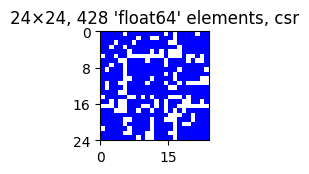

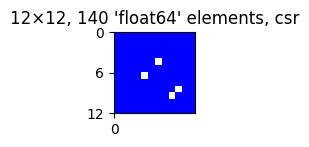

In [31]:
spy(sp.sparse.csr_matrix(item_similarity_matrix))
spy(sp.sparse.csr_matrix(user_similarity_matrix))

In [32]:
item_ids = user_item_matrix_df.columns

item_encoder = LabelEncoder()
item_ids_encoded = item_encoder.fit_transform(item_ids)

similarity_rec = SimilarityRecommender(10)
similarity_rec.fit(item_similarity_matrix)
item_recs = similarity_rec.recommend(item_ids_encoded)

results = [item_encoder.inverse_transform(item).tolist() for item in item_recs]
similarity_recommendations_toy = {item_id: result for item_id, result in zip(item_ids, results)}

if OVERWRITE:
    with open("../../tests/test_data/similarity_recommendations_toy.json", "w") as f:
        f.write(json.dumps(similarity_recommendations_toy, indent=4))

    item_probs = similarity_rec.predict_proba(item_ids_encoded).toarray().astype(np.float32).round(6)
    np.save("../../tests/test_data/similarity_recommendations_toy_probs.npy", item_probs)